## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [34]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.01,0.05,0.1]
redice_lr_patient = [1,2,5]

In [35]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor = 0.01,
                                  min_lr = 1e-12,
                                  monitor ='val_loss',
                                  patience = 1,
                                  verbose = 1)
                                 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.01, reduce_patient: 1
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_33 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________


49/49 [==============================] - 2s 31ms/step - loss: 2.9810 - accuracy: 0.0986 - val_loss: 2.8239 - val_accuracy: 0.0986
Epoch 11/25
49/49 [==============================] - 1s 31ms/step - loss: 2.9866 - accuracy: 0.0987 - val_loss: 2.8647 - val_accuracy: 0.0999
Epoch 12/25
49/49 [==============================] - 2s 33ms/step - loss: 2.9730 - accuracy: 0.0970 - val_loss: 2.8971 - val_accuracy: 0.1005
Epoch 13/25
49/49 [==============================] - 2s 31ms/step - loss: 2.9858 - accuracy: 0.0952 - val_loss: 2.9222 - val_accuracy: 0.0999
Epoch 14/25
49/49 [==============================] - 2s 31ms/step - loss: 2.9960 - accuracy: 0.0976 - val_loss: 2.9415 - val_accuracy: 0.0998
Epoch 15/25
49/49 [==============================] - 2s 32ms/step - loss: 2.9844 - accuracy: 0.0989 - val_loss: 2.9550 - val_accuracy: 0.0998
Epoch 16/25
49/49 [==============================] - 2s 35ms/step - loss: 2.9808 - accuracy: 0.0978 - val_loss: 2.9645 - val_accuracy: 0.0994
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 2s 33ms/step - loss: 3.0894 - accuracy: 0.0900 - val_loss: 2.3672 - val_accuracy: 0.0902
Epoch 2/25
49/49 [==============================] - 1s 29ms/step - loss: 3.0829 - accuracy: 0.0914 - val_loss: 2.3959 - val_accuracy: 0.0944
Epoch 3/25
49/49 [==============================] - 1s 30ms/step - loss: 3.0774 - accuracy: 0.0934 - val_loss: 2.4383 - val_accuracy: 0.0957
Epoch 4/25
49/49 [==============================] - 2s 31ms/step - loss: 3.0797 - accuracy: 0.0925 - val_loss: 2.4972 - val_accuracy: 0.0960
Epoch 5/25
49/49 [==============================] - 2s 31ms/step - loss: 3.0819 - accuracy: 0.0937 - val_loss: 2.5684 - val_accuracy: 0.0976
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 3.0889 - accuracy: 0.0889 - val_loss: 2.6452 - val_accuracy: 0.0944
Epoch 7/25
49/49 [==============================] - 1s 29ms/step - loss: 3.0844 - accuracy: 0.0920 - val_loss: 2.7214 - val_accuracy: 0.0915
Epoch 8/25
49

49/49 [==============================] - 1s 31ms/step - loss: 2.9124 - accuracy: 0.1195 - val_loss: 2.9020 - val_accuracy: 0.1178
Epoch 24/25
49/49 [==============================] - 2s 32ms/step - loss: 2.9088 - accuracy: 0.1187 - val_loss: 2.9022 - val_accuracy: 0.1178
Epoch 25/25
49/49 [==============================] - 1s 29ms/step - loss: 2.9092 - accuracy: 0.1183 - val_loss: 2.9023 - val_accuracy: 0.1178
Numbers of exp: 5, reduce_factor: 0.05, reduce_patient: 5
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_48 (Batc (None, 256)               1024      
________________________________________________

49/49 [==============================] - 2s 31ms/step - loss: 3.1088 - accuracy: 0.0982 - val_loss: 2.9289 - val_accuracy: 0.0981
Epoch 11/25
49/49 [==============================] - 1s 30ms/step - loss: 3.1136 - accuracy: 0.0984 - val_loss: 2.9721 - val_accuracy: 0.0982
Epoch 12/25
49/49 [==============================] - 1s 30ms/step - loss: 3.1103 - accuracy: 0.0994 - val_loss: 3.0078 - val_accuracy: 0.0985
Epoch 13/25
49/49 [==============================] - 1s 30ms/step - loss: 3.1030 - accuracy: 0.0978 - val_loss: 3.0360 - val_accuracy: 0.0979
Epoch 14/25
49/49 [==============================] - 2s 33ms/step - loss: 3.1121 - accuracy: 0.0997 - val_loss: 3.0575 - val_accuracy: 0.0971
Epoch 15/25
49/49 [==============================] - 2s 31ms/step - loss: 3.1116 - accuracy: 0.0967 - val_loss: 3.0734 - val_accuracy: 0.0981
Epoch 16/25
49/49 [==============================] - 1s 30ms/step - loss: 3.1044 - accuracy: 0.0984 - val_loss: 3.0844 - val_accuracy: 0.0980
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 2s 33ms/step - loss: 3.1052 - accuracy: 0.0930 - val_loss: 2.3262 - val_accuracy: 0.1074
Epoch 2/25
49/49 [==============================] - 1s 29ms/step - loss: 3.1000 - accuracy: 0.0936 - val_loss: 2.3488 - val_accuracy: 0.1210
Epoch 3/25
49/49 [==============================] - 1s 29ms/step - loss: 3.1070 - accuracy: 0.0929 - val_loss: 2.4069 - val_accuracy: 0.1148
Epoch 4/25
49/49 [==============================] - 2s 31ms/step - loss: 3.0981 - accuracy: 0.0948 - val_loss: 2.4826 - val_accuracy: 0.1087
Epoch 5/25
49/49 [==============================] - 2s 32ms/step - loss: 3.1051 - accuracy: 0.0932 - val_loss: 2.5668 - val_accuracy: 0.1009
Epoch 6/25
49/49 [==============================] - 2s 31ms/step - loss: 3.1006 - accuracy: 0.0918 - val_loss: 2.6517 - val_accuracy: 0.0979
Epoch 7/25
49/49 [==============================] - 1s 31ms/step - loss: 3.1028 - accuracy: 0.0934 - val_loss: 2.7326 - val_accuracy: 0.0966
Epoch 8/25
49

49/49 [==============================] - 1s 30ms/step - loss: 1.1334 - accuracy: 0.6035 - val_loss: 1.3423 - val_accuracy: 0.5244
Epoch 22/25
49/49 [==============================] - 1s 30ms/step - loss: 1.1279 - accuracy: 0.6090 - val_loss: 1.3423 - val_accuracy: 0.5244
Epoch 23/25
49/49 [==============================] - 2s 33ms/step - loss: 1.1328 - accuracy: 0.6033 - val_loss: 1.3423 - val_accuracy: 0.5243
Epoch 24/25
49/49 [==============================] - 2s 31ms/step - loss: 1.1262 - accuracy: 0.6099 - val_loss: 1.3423 - val_accuracy: 0.5245
Epoch 25/25
49/49 [==============================] - 1s 30ms/step - loss: 1.1301 - accuracy: 0.6068 - val_loss: 1.3423 - val_accuracy: 0.5247
Numbers of exp: 10, reduce_factor: 0.01, reduce_patient: 2
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 3072)]            0         
___________________________

49/49 [==============================] - 1s 30ms/step - loss: 2.9769 - accuracy: 0.1094 - val_loss: 2.6882 - val_accuracy: 0.1205
Epoch 9/25
49/49 [==============================] - 2s 32ms/step - loss: 2.9744 - accuracy: 0.1132 - val_loss: 2.7454 - val_accuracy: 0.1190
Epoch 10/25
49/49 [==============================] - 2s 32ms/step - loss: 2.9755 - accuracy: 0.1111 - val_loss: 2.7956 - val_accuracy: 0.1195
Epoch 11/25
49/49 [==============================] - 2s 34ms/step - loss: 2.9806 - accuracy: 0.1116 - val_loss: 2.8382 - val_accuracy: 0.1190
Epoch 12/25
49/49 [==============================] - 2s 34ms/step - loss: 2.9704 - accuracy: 0.1113 - val_loss: 2.8726 - val_accuracy: 0.1193
Epoch 13/25
49/49 [==============================] - 2s 35ms/step - loss: 2.9707 - accuracy: 0.1095 - val_loss: 2.8998 - val_accuracy: 0.1181
Epoch 14/25
49/49 [==============================] - 2s 36ms/step - loss: 2.9737 - accuracy: 0.1100 - val_loss: 2.9200 - val_accuracy: 0.1186
Epoch 15/25
49/49 [

Epoch 1/25
49/49 [==============================] - 2s 33ms/step - loss: 2.9885 - accuracy: 0.1116 - val_loss: 2.3300 - val_accuracy: 0.1171
Epoch 2/25
49/49 [==============================] - 1s 29ms/step - loss: 2.9860 - accuracy: 0.1095 - val_loss: 2.3682 - val_accuracy: 0.0913
Epoch 3/25
49/49 [==============================] - 1s 29ms/step - loss: 2.9875 - accuracy: 0.1116 - val_loss: 2.4418 - val_accuracy: 0.0906
Epoch 4/25
49/49 [==============================] - 1s 29ms/step - loss: 2.9925 - accuracy: 0.1101 - val_loss: 2.5171 - val_accuracy: 0.0927
Epoch 5/25
49/49 [==============================] - 2s 32ms/step - loss: 2.9937 - accuracy: 0.1104 - val_loss: 2.5836 - val_accuracy: 0.0965
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 2.9780 - accuracy: 0.1118 - val_loss: 2.6429 - val_accuracy: 0.0984
Epoch 7/25
49/49 [==============================] - 1s 29ms/step - loss: 2.9853 - accuracy: 0.1110 - val_loss: 2.6970 - val_accuracy: 0.1020
Epoch 8/25
49

49/49 [==============================] - 1s 30ms/step - loss: 2.8997 - accuracy: 0.1218 - val_loss: 2.8995 - val_accuracy: 0.1203
Epoch 24/25
49/49 [==============================] - 2s 33ms/step - loss: 2.8989 - accuracy: 0.1199 - val_loss: 2.8997 - val_accuracy: 0.1204
Epoch 25/25
49/49 [==============================] - 1s 30ms/step - loss: 2.8984 - accuracy: 0.1201 - val_loss: 2.8998 - val_accuracy: 0.1204
Numbers of exp: 15, reduce_factor: 0.10, reduce_patient: 1
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_78 (Batc (None, 256)               1024      
_______________________________________________

49/49 [==============================] - 2s 31ms/step - loss: 3.0810 - accuracy: 0.1005 - val_loss: 2.9243 - val_accuracy: 0.0940
Epoch 11/25
49/49 [==============================] - 2s 33ms/step - loss: 3.0839 - accuracy: 0.0988 - val_loss: 2.9705 - val_accuracy: 0.0936
Epoch 12/25
49/49 [==============================] - 2s 31ms/step - loss: 3.0833 - accuracy: 0.1019 - val_loss: 3.0066 - val_accuracy: 0.0942
Epoch 13/25
49/49 [==============================] - 2s 32ms/step - loss: 3.0837 - accuracy: 0.0994 - val_loss: 3.0345 - val_accuracy: 0.0932
Epoch 14/25
49/49 [==============================] - 1s 30ms/step - loss: 3.0915 - accuracy: 0.0966 - val_loss: 3.0552 - val_accuracy: 0.0931
Epoch 15/25
49/49 [==============================] - 1s 30ms/step - loss: 3.0790 - accuracy: 0.1035 - val_loss: 3.0702 - val_accuracy: 0.0934
Epoch 16/25
49/49 [==============================] - 1s 31ms/step - loss: 3.0844 - accuracy: 0.1006 - val_loss: 3.0807 - val_accuracy: 0.0925
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 3s 38ms/step - loss: 2.1095 - accuracy: 0.3040 - val_loss: 2.5248 - val_accuracy: 0.1678
Epoch 2/25
49/49 [==============================] - 2s 38ms/step - loss: 1.5503 - accuracy: 0.4494 - val_loss: 2.3982 - val_accuracy: 0.1931
Epoch 3/25
49/49 [==============================] - 2s 35ms/step - loss: 1.4277 - accuracy: 0.4945 - val_loss: 1.8736 - val_accuracy: 0.3391
Epoch 4/25
49/49 [==============================] - 2s 36ms/step - loss: 1.3550 - accuracy: 0.5192 - val_loss: 1.8923 - val_accuracy: 0.3475

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 5/25
49/49 [==============================] - 2s 37ms/step - loss: 1.2641 - accuracy: 0.5543 - val_loss: 1.5115 - val_accuracy: 0.4587
Epoch 6/25
49/49 [==============================] - 2s 37ms/step - loss: 1.2309 - accuracy: 0.5657 - val_loss: 1.4251 - val_accuracy: 0.4850
Epoch 7/25
49/49 [==============================] - 2s 34ms/step - loss:

Epoch 23/25
49/49 [==============================] - 2s 34ms/step - loss: 1.4902 - accuracy: 0.4777 - val_loss: 1.6267 - val_accuracy: 0.4388
Epoch 24/25
49/49 [==============================] - 2s 34ms/step - loss: 1.4802 - accuracy: 0.4870 - val_loss: 1.6239 - val_accuracy: 0.4387
Epoch 25/25
49/49 [==============================] - 2s 34ms/step - loss: 1.4768 - accuracy: 0.4832 - val_loss: 1.6139 - val_accuracy: 0.4421
Numbers of exp: 20, reduce_factor: 0.01, reduce_patient: 5
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_93 (Batc (None, 256)               1024      
___________________________________

49/49 [==============================] - 2s 35ms/step - loss: 1.7528 - accuracy: 0.3891 - val_loss: 1.7881 - val_accuracy: 0.3759
Epoch 11/25
49/49 [==============================] - 2s 34ms/step - loss: 1.7223 - accuracy: 0.3993 - val_loss: 1.7745 - val_accuracy: 0.3852
Epoch 12/25
49/49 [==============================] - 2s 35ms/step - loss: 1.6870 - accuracy: 0.4090 - val_loss: 1.7633 - val_accuracy: 0.3858
Epoch 13/25
49/49 [==============================] - 2s 36ms/step - loss: 1.6682 - accuracy: 0.4170 - val_loss: 1.7500 - val_accuracy: 0.3934
Epoch 14/25
49/49 [==============================] - 2s 32ms/step - loss: 1.6387 - accuracy: 0.4271 - val_loss: 1.7365 - val_accuracy: 0.3970
Epoch 15/25
49/49 [==============================] - 2s 33ms/step - loss: 1.6310 - accuracy: 0.4265 - val_loss: 1.7230 - val_accuracy: 0.4041
Epoch 16/25
49/49 [==============================] - 2s 35ms/step - loss: 1.6215 - accuracy: 0.4324 - val_loss: 1.7157 - val_accuracy: 0.4050
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 2s 37ms/step - loss: 2.6847 - accuracy: 0.1503 - val_loss: 2.2457 - val_accuracy: 0.1804
Epoch 2/25
49/49 [==============================] - 2s 34ms/step - loss: 2.2736 - accuracy: 0.2493 - val_loss: 2.1603 - val_accuracy: 0.2379
Epoch 3/25
49/49 [==============================] - 2s 33ms/step - loss: 2.1092 - accuracy: 0.2904 - val_loss: 2.0671 - val_accuracy: 0.2704
Epoch 4/25
49/49 [==============================] - 2s 33ms/step - loss: 1.9995 - accuracy: 0.3222 - val_loss: 1.9769 - val_accuracy: 0.3015
Epoch 5/25
49/49 [==============================] - 2s 36ms/step - loss: 1.9293 - accuracy: 0.3393 - val_loss: 1.9068 - val_accuracy: 0.3263
Epoch 6/25
49/49 [==============================] - 2s 35ms/step - loss: 1.8626 - accuracy: 0.3592 - val_loss: 1.8593 - val_accuracy: 0.3447
Epoch 7/25
49/49 [==============================] - 2s 34ms/step - loss: 1.8258 - accuracy: 0.3699 - val_loss: 1.8201 - val_accuracy: 0.3624
Epoch 8/25
49

49/49 [==============================] - 2s 34ms/step - loss: 1.5089 - accuracy: 0.4740 - val_loss: 1.6398 - val_accuracy: 0.4306
Epoch 24/25
49/49 [==============================] - 2s 35ms/step - loss: 1.5005 - accuracy: 0.4775 - val_loss: 1.6321 - val_accuracy: 0.4334
Epoch 25/25
49/49 [==============================] - 2s 34ms/step - loss: 1.4943 - accuracy: 0.4819 - val_loss: 1.6289 - val_accuracy: 0.4345
Numbers of exp: 25, reduce_factor: 0.10, reduce_patient: 2
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_108 (Bat (None, 256)               1024      
_______________________________________________

49/49 [==============================] - 2s 41ms/step - loss: 1.7414 - accuracy: 0.3938 - val_loss: 1.7743 - val_accuracy: 0.3787
Epoch 11/25
49/49 [==============================] - 2s 35ms/step - loss: 1.7069 - accuracy: 0.4056 - val_loss: 1.7567 - val_accuracy: 0.3846
Epoch 12/25
49/49 [==============================] - 1s 31ms/step - loss: 1.6878 - accuracy: 0.4135 - val_loss: 1.7470 - val_accuracy: 0.3911
Epoch 13/25
49/49 [==============================] - 2s 34ms/step - loss: 1.6604 - accuracy: 0.4241 - val_loss: 1.7336 - val_accuracy: 0.3970
Epoch 14/25
49/49 [==============================] - 2s 36ms/step - loss: 1.6477 - accuracy: 0.4266 - val_loss: 1.7273 - val_accuracy: 0.3974
Epoch 15/25
49/49 [==============================] - 2s 31ms/step - loss: 1.6214 - accuracy: 0.4405 - val_loss: 1.7133 - val_accuracy: 0.4032
Epoch 16/25
49/49 [==============================] - 2s 31ms/step - loss: 1.6080 - accuracy: 0.4406 - val_loss: 1.7033 - val_accuracy: 0.4076
Epoch 17/25
49/49 

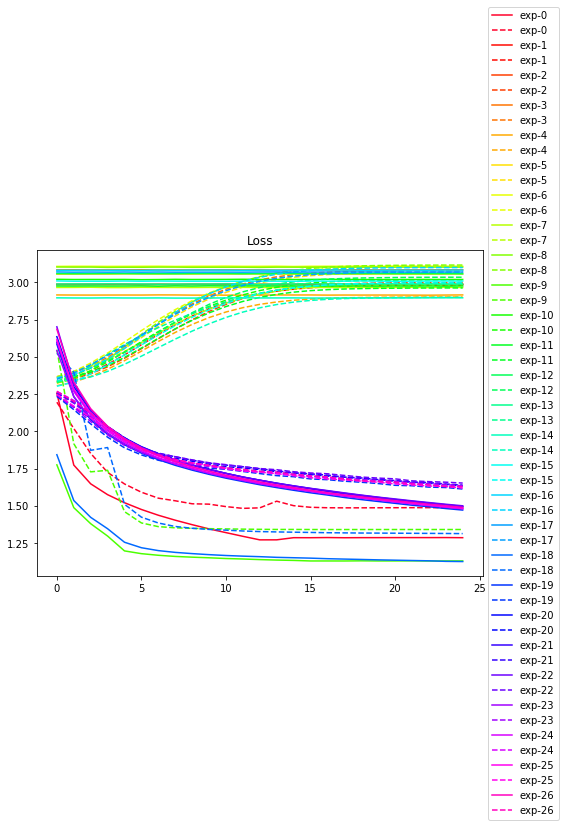

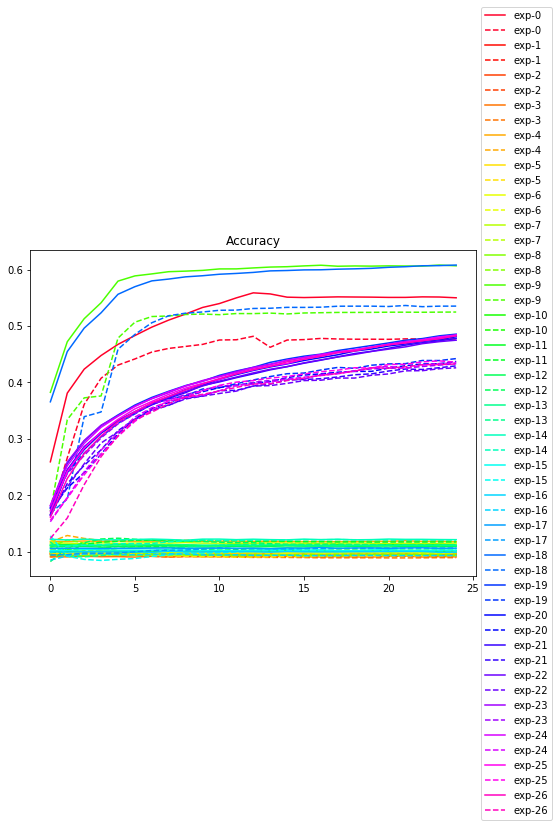

In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()